In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from tqdm import trange, tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

In [2]:
#Dataset already shuffled
dataset = np.load(os.path.abspath('cats_dogs_data.npy'), allow_pickle=True)

#Segment Dataset into X and y
dataset_X = torch.Tensor([i[0]/255 for i in dataset]).view(-1, 1, 50, 50)
dataset_y = torch.Tensor([j[1] for j in dataset])

#Segment Dataset into training and testing
test_num = 2494
train_X = dataset_X[:-test_num]
train_y = dataset_y[:-test_num]

test_X = dataset_X[-test_num:]
test_y = dataset_y[-test_num:]

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*6*6)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [69]:
def train(epochs):
    losses, accs = [],[]
    for epoch in range(epochs):
        for batch in (t := trange(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[batch:batch+BATCH_SIZE].view(-1, 1, 50, 50).cuda()
            batch_y = train_y[batch:batch+BATCH_SIZE]
            temp = torch.Tensor([torch.argmax(u).int() for u in batch_y]).long().cuda()

            model.zero_grad()
            out = model(batch_X)
            loss = F.nll_loss(out, temp)
            loss.backward()
            optimiser.step()
            preds = [torch.argmax(i) for i in out]
            acc = np.array([int(a)==int(b) for a,b in zip(preds,temp)]).mean()
            losses.append(loss)
            accs.append(acc)
            t.set_description(f'Loss :: {loss}')
    print(f'Epoch {epoch} :: Loss {loss}')
    return losses,accs

In [83]:
def test():
    with torch.no_grad():
        accs = []
        
        out = model(test_X.view(-1, 1, 50, 50).cuda())
        temp = torch.Tensor([torch.argmax(u).int() for u in test_y]).long().cuda()
        preds = [torch.argmax(i) for i in out]
        acc = np.array([int(a)==int(b) for a,b in zip(preds,temp)]).mean()
        accs.append(acc)
        #t.set_description(f'Acc :: {accs[-1]}')
    return accs

In [75]:
model = Net().cuda()

BATCH_SIZE = 100
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [76]:
l, a = train(15)

Loss :: 0.09258206188678741: 100%|███████████████████████████████████████████████████| 225/225 [00:11<00:00, 19.87it/s]

Epoch 14 :: Loss 0.09258206188678741


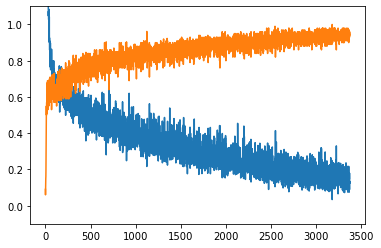

In [92]:
plt.ylim(-0.1, 1.1)
plt.plot(l)
plt.plot(a)

In [95]:
np.array(a[-100:]).mean()

0.9426230769230769

In [90]:
acc = test()

In [91]:
acc

[0.8360064153969526]